CNN-Based Weather Classification Using Keras

Install & Import Libraries

In [1]:
import os
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


Extract Dataset from ZIP

In [3]:
# Define paths
zip_path = "/content/weather-image-dataset.zip"
extract_path = "/content/weather_dataset"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check structure
for folder in os.listdir(extract_path):
    print(folder, "->", len(os.listdir(os.path.join(extract_path, folder))), "images")


cloudy -> 350 images
sunrise -> 349 images
lightning -> 400 images
rainy -> 383 images


Create Train-Test Split

In [ ]:
!pip install split-folders
import splitfolders  # Only needed once per Colab

# Install if not available


# Split into train/val (80/20)
splitfolders.ratio(extract_path, output="/content/weather_split", seed=42, ratio=(0.8, 0.2))


Copying files: 1482 files [00:00, 4530.40 files/s]


Data Preprocessing

In [ ]:
train_dir = "/content/weather_split/train"
val_dir = "/content/weather_split/val"

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')


Found 1185 images belonging to 4 classes.
Found 297 images belonging to 4 classes.


Define the CNN Model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the Model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train the Model

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5157 - loss: 1.0979 - val_accuracy: 0.8283 - val_loss: 0.5337
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7996 - loss: 0.5713 - val_accuracy: 0.8148 - val_loss: 0.4660
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8342 - loss: 0.4941 - val_accuracy: 0.8586 - val_loss: 0.3661
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8604 - loss: 0.4112 - val_accuracy: 0.9125 - val_loss: 0.2943
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9175 - loss: 0.2662 - val_accuracy: 0.8956 - val_loss: 0.3261
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.9392 - loss: 0.1958 - val_accuracy: 0.9192 - val_loss: 0.2316
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9504 - loss: 0.1565 - val_accuracy: 0.9226 - val_loss: 0.2480
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9492 - loss: 0.1497 - val_accuracy: 0.9495 - val_loss:

Plot Accuracy and Loss

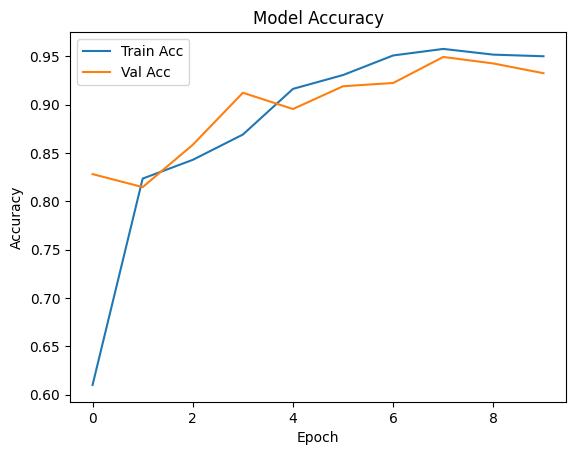

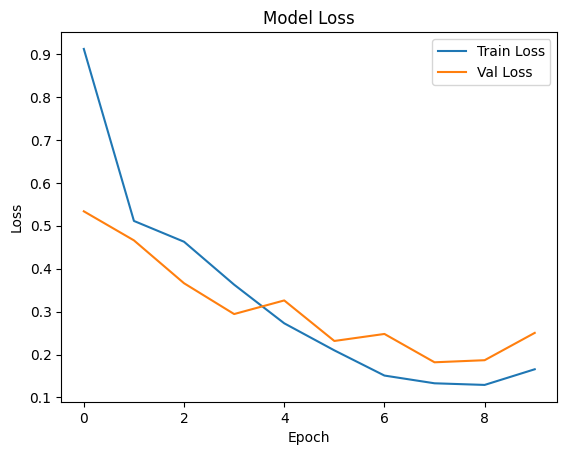

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Evaluate with Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step


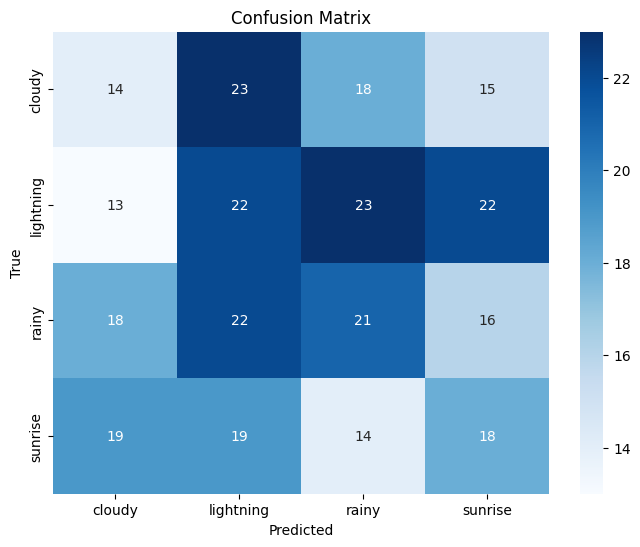

              precision    recall  f1-score   support

      cloudy       0.22      0.20      0.21        70
   lightning       0.26      0.28      0.27        80
       rainy       0.28      0.27      0.27        77
     sunrise       0.25      0.26      0.26        70

    accuracy                           0.25       297
   macro avg       0.25      0.25      0.25       297
weighted avg       0.25      0.25      0.25       297



In [ ]:
val_gen.reset()
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))
